# Number of side chain atoms

Definition of side chain atoms:

- heavy atom
- not backbone atom 
- not terminal carboxy O atom

For all KLIFS structures, check number of atoms matching these conditions. Check if in agreement with manual atom number assignment:

In [1]:
N_HEAVY_ATOMS = {
    'ALA': 1,
    'ARG': 7,
    'ASN': 4,
    'ASP': 4,
    'CYS': 2,
    'GLN': 5,
    'GLU': 5,
    'GLY': 0,
    'HIS': 6,
    'ILE': 4,
    'LEU': 4,
    'LYS': 5,
    'MET': 4,
    'PHE': 7,
    'PRO': 3,
    'SER': 2,
    'THR': 3,
    'TRP': 10,
    'TYR': 8,
    'VAL': 3
}

## Imports

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import multiprocessing
from pathlib import Path
import pickle
import sys

import nglview as nv
import pandas as pd

sys.path.append('./../..')
from kissim.auxiliary import PdbChainLoader 

_ColormakerRegistry()

## IO paths

In [5]:
path_to_kinsim = Path('.') / '..' / '..'
path_to_data = path_to_kinsim / 'examples' / 'data'
path_to_results = path_to_kinsim / 'examples' / 'results' / 'features' / 'sca_centroid_wo_backbone' 

## Load KLIFS metadata

In [6]:
klifs_metadata = pd.read_csv(path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv' , index_col=0)

In [7]:
klifs_metadata.shape

(3878, 23)

## Data generation

In [ ]:
klifs_metadata_entry = klifs_metadata.iloc[0].squeeze()

In [8]:
def get_atoms_from_residue(klifs_metadata_entry):
    
    pdb = PdbChainLoader(klifs_metadata_entry=klifs_metadata_entry)
    
    results = []

    for residue in pdb.chain.get_residues():

        heavy_atoms = [atom for atom in residue.get_atoms() if (atom.fullname not in 'N CA C O OXT'.split()) & (not atom.get_id().startswith('H'))]
        
        results.append(
            [residue.get_id()[1], residue.get_resname(), len(heavy_atoms), klifs_metadata_entry.code]
        )

    return pd.DataFrame(results, columns='residue_id residue_name n_heavy_atoms klifs_code'.split())

In [9]:
def get_atoms_from_residues(klifs_metadata):
    
    # Number of CPUs on machine
    num_cores = multiprocessing.cpu_count() - 1

    # List of entries to be processed
    entry_list = [j for i, j in klifs_metadata.iterrows()]
    print(f'{len(entry_list)} entries to be processed.')

    # Create pool with `num_cores` processes
    pool = multiprocessing.Pool(processes=num_cores)

    # Apply function to each chunk in list
    results = pool.map(get_atoms_from_residue, entry_list)
    print(f'{len(results)} entries processed.')

    pool.close()
    pool.join()
    
    return pd.concat(results, axis=0)

## Data analysis

In [10]:
with open(path_to_results / 'number_side_chain_atoms.p', 'rb') as f:
    data = pickle.load(f)

### Statistics

In [11]:
stats = data.groupby('residue_name').describe()

In [13]:
stats[stats[('residue_id', 'count')] > 2000]['n_heavy_atoms']

,count,mean,std,min,25%,50%,75%,max
residue_name,,,,,,,,
ALA,70486.0,0.999248,0.027411,0.0,1.0,1.0,1.0,1.0
ARG,70269.0,6.723975,1.226766,0.0,7.0,7.0,7.0,7.0
ASN,46032.0,3.952555,0.374863,0.0,4.0,4.0,4.0,4.0
ASP,73425.0,3.957181,0.355156,0.0,4.0,4.0,4.0,4.0
CYS,21807.0,1.996056,0.072829,0.0,2.0,2.0,2.0,2.0
GLN,47240.0,4.854742,0.739244,0.0,5.0,5.0,5.0,5.0
GLU,88888.0,4.823474,0.812208,0.0,5.0,5.0,5.0,5.0
GLY,70026.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
HIS,38554.0,5.952430,0.485271,0.0,6.0,6.0,6.0,6.0


### Residue count

In [14]:
residue_count = stats[stats[('residue_id', 'count')] > 2000][('n_heavy_atoms', 'count')]

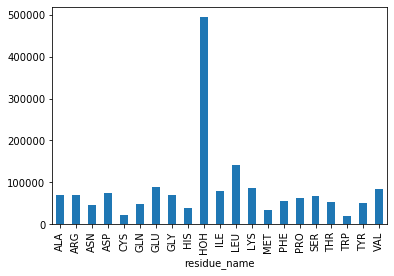

In [16]:
residue_count.plot(kind='bar')

### Irregular residues (missing atoms)

In [17]:
def get_irregular_residues(by_residue):
    group_by_residue = data.groupby('residue_name').get_group(by_residue)
    
    
    irregaular_residues = group_by_residue[group_by_residue.n_heavy_atoms < N_HEAVY_ATOMS[by_residue]]
    
    print(f'Percentage of irregular atom numbers for {by_residue}: {round(len(irregaular_residues)/float(len(group_by_residue))*100, 2)}%')
    
    return irregaular_residues

In [18]:
for key, value in N_HEAVY_ATOMS.items():
    get_irregular_residues(key)

Percentage of irregular atom numbers for ALA: 0.08%
Percentage of irregular atom numbers for ARG: 4.95%
Percentage of irregular atom numbers for ASN: 1.59%
Percentage of irregular atom numbers for ASP: 1.45%
Percentage of irregular atom numbers for CYS: 0.33%
Percentage of irregular atom numbers for GLN: 3.77%
Percentage of irregular atom numbers for GLU: 4.57%
Percentage of irregular atom numbers for GLY: 0.0%
Percentage of irregular atom numbers for HIS: 0.96%
Percentage of irregular atom numbers for ILE: 0.92%
Percentage of irregular atom numbers for LEU: 0.81%
Percentage of irregular atom numbers for LYS: 8.2%
Percentage of irregular atom numbers for MET: 1.16%
Percentage of irregular atom numbers for PHE: 0.77%
Percentage of irregular atom numbers for PRO: 0.14%
Percentage of irregular atom numbers for SER: 1.15%
Percentage of irregular atom numbers for THR: 0.83%
Percentage of irregular atom numbers for TRP: 0.31%
Percentage of irregular atom numbers for TYR: 0.71%
Percentage of 

Take a closer a look at LYS...

In [19]:
def check_irregular_residues(by_residue):
    print(f'Regular atom number for {by_residue}: {N_HEAVY_ATOMS[by_residue]}')
    return get_irregular_residues(by_residue).groupby('n_heavy_atoms').size()

In [20]:
check_irregular_residues('LYS')

Regular atom number for LYS: 5
Percentage of irregular atom numbers for LYS: 8.2%


n_heavy_atoms
0      18
1    4887
2    1047
3     858
4     260
dtype: int64

In [21]:
check_irregular_residues('ARG')

Regular atom number for ARG: 7
Percentage of irregular atom numbers for ARG: 4.95%


n_heavy_atoms
0      58
1    2612
2     328
3     265
4     186
5      28
6       4
dtype: int64

## Visualisation

Initially, I only defined side chain atoms as (i) heavy atoms and (ii) not part of the backbone. However, in the statistic I could see that sometimes there is one atom more present - after visual inspection here, I found out that these additional atoms are terminal carboxyl O atoms (`OXT`). Thus, I extended the side chain atoms definition by this atom type.

In [22]:
def create_viewer(pdb_id):

    viewer = nv.NGLWidget()
    viewer.add_pdbid(pdb_id)
    viewer.add_representation(repr_type='cartoon', selection='all')

    return viewer

In [23]:
viewer = create_viewer('1e9h')
viewer

NGLWidget()

In [24]:
viewer.add_ball_and_stick(selection='296')

In [25]:
viewer.center(selection='296:A')

What about terminal amino N-atoms? All good.

From https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html:
> Note that this residue includes the extra oxygen atom OXT on the terminal carboxyl group. Other than OXT and the rarely seen HXT, atoms in standard nucleotides and amino acids in version 3.0 PDB files are named according to the IUPAC recommendations (Pure Appl Chem 70:117 (1998)). The TER record terminates the amino acid chain. 

In [26]:
viewer2 = create_viewer('1e9h')
viewer2

NGLWidget()

In [27]:
viewer2.add_ball_and_stick(selection='1')

In [28]:
viewer2.center(selection='1:A')